# ECA57 Database Exploration

Explore the synthesized ECA57 identity circuits using skeleton graphs and analyze irreducible circuits.

## 1. Setup

In [1]:
import sys
sys.path.insert(0, '/Users/egementunca/research-group/sat_revsynth/src')

import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

from gates.eca57 import ECA57Circuit, ECA57Gate

print('Imports loaded!')

Imports loaded!


## 2. Load ECA57 Database

In [2]:
# Load synthesized ECA57 identities
DB_PATH = '/Users/egementunca/research-group/sat_revsynth/data/eca57_identities_w4g7.pickle'

with open(DB_PATH, 'rb') as f:
    db = pickle.load(f)

print('=== ECA57 Identity Database ===')
print(f'Keys: {list(db.keys())}')
print()

total_circuits = 0
for key in sorted(db.keys()):
    info = db[key]
    count = info['num_classes']
    total_circuits += count
    print(f"{key}: {count:>6} equiv classes ({info['time']:.1f}s)")

print(f"\nTotal: {total_circuits} circuits")

=== ECA57 Identity Database ===
Keys: ['w3g2', 'w3g3', 'w3g4', 'w3g5', 'w3g6', 'w3g7', 'w4g2', 'w4g3', 'w4g4', 'w4g5', 'w4g6', 'w4g7']

w3g2:      6 equiv classes (0.0s)
w3g3:      0 equiv classes (0.0s)
w3g4:     72 equiv classes (0.1s)
w3g5:      0 equiv classes (0.0s)
w3g6:   1308 equiv classes (1.0s)
w3g7:      0 equiv classes (0.0s)
w4g2:     24 equiv classes (0.0s)
w4g3:      0 equiv classes (0.0s)
w4g4:   1296 equiv classes (0.7s)
w4g5:      0 equiv classes (0.0s)
w4g6: 103632 equiv classes (2280.5s)
w4g7:   8064 equiv classes (3.0s)

Total: 114402 circuits


## 3. Build Circuit Objects

In [3]:
def load_circuits(db, key):
    """Load circuits from database entry."""
    info = db[key]
    width = info['width']
    circuits = []
    for tuples in info['circuits']:
        c = ECA57Circuit.from_tuple_list(width, tuples)
        circuits.append(c)
    return circuits

# Load all circuits organized by (width, gate_count)
all_circuits = {}
for key in db.keys():
    all_circuits[key] = load_circuits(db, key)
    
print('Loaded all circuits into memory.')
for key, circs in all_circuits.items():
    print(f'  {key}: {len(circs)} circuits')

Loaded all circuits into memory.
  w3g2: 6 circuits
  w3g3: 0 circuits
  w3g4: 72 circuits
  w3g5: 0 circuits
  w3g6: 1308 circuits
  w3g7: 0 circuits
  w4g2: 24 circuits
  w4g3: 0 circuits
  w4g4: 1296 circuits
  w4g5: 0 circuits
  w4g6: 103632 circuits
  w4g7: 8064 circuits


In [18]:
print(all_circuits["w4g7"][0])

ECA57 Circuit (width=4, gates=7)
  [0] target=3, ctrl1=0, ctrl2=1
  [1] target=2, ctrl1=1, ctrl2=0
  [2] target=3, ctrl1=2, ctrl2=0
  [3] target=3, ctrl1=0, ctrl2=2
  [4] target=2, ctrl1=1, ctrl2=0
  [5] target=3, ctrl1=1, ctrl2=2
  [6] target=3, ctrl1=2, ctrl2=1


## 4. Basic Statistics

In [4]:
def analyze_gate_patterns(circuits):
    """Analyze gate usage patterns in circuits."""
    target_counts = Counter()
    ctrl1_counts = Counter()
    ctrl2_counts = Counter()
    gate_tuples = Counter()
    
    for c in circuits:
        for g in c.gates():
            target_counts[g.target] += 1
            ctrl1_counts[g.ctrl1] += 1
            ctrl2_counts[g.ctrl2] += 1
            gate_tuples[g.to_tuple()] += 1
    
    return {
        'target_counts': target_counts,
        'ctrl1_counts': ctrl1_counts,
        'ctrl2_counts': ctrl2_counts,
        'gate_tuples': gate_tuples,
        'unique_gates': len(gate_tuples),
        'total_gates': sum(gate_tuples.values())
    }

# Analyze w4g4 and w4g6
for key in ['w4g4', 'w4g6']:
    if key not in all_circuits:
        continue
    stats = analyze_gate_patterns(all_circuits[key])
    print(f'\n=== {key} Statistics ===')
    print(f'Circuits: {len(all_circuits[key])}')
    print(f'Total gates: {stats["total_gates"]}')
    print(f'Unique gate patterns: {stats["unique_gates"]}')
    print(f'\nTop 5 gate patterns:')
    for pattern, count in stats['gate_tuples'].most_common(5):
        print(f'  ({pattern[0]},{pattern[1]},{pattern[2]}): {count}')


=== w4g4 Statistics ===
Circuits: 1296
Total gates: 5184
Unique gate patterns: 24

Top 5 gate patterns:
  (3,2,1): 216
  (2,3,1): 216
  (3,1,2): 216
  (1,3,2): 216
  (2,1,3): 216

=== w4g6 Statistics ===
Circuits: 103632
Total gates: 621792
Unique gate patterns: 24

Top 5 gate patterns:
  (3,2,1): 25908
  (2,3,1): 25908
  (3,1,2): 25908
  (1,3,2): 25908
  (2,1,3): 25908


## 5. Skeleton Graph Analysis

In [5]:
import networkx as nx

def build_eca57_skeleton(circuit):
    """Build skeleton graph for ECA57 circuit.
    
    Nodes = gates
    Edges = dependencies (target->control collisions)
    """
    width = circuit.width()
    gates = circuit.gates()
    
    G = nx.DiGraph()
    
    # Add gate nodes
    for i, g in enumerate(gates):
        G.add_node(i, gate=g)
    
    # Track last writer to each wire
    last_writer = {}  # wire -> gate index
    
    for i, g in enumerate(gates):
        # Check if this gate reads from wires modified by earlier gates
        for ctrl in [g.ctrl1, g.ctrl2]:
            if ctrl in last_writer:
                G.add_edge(last_writer[ctrl], i, edge_type='active->ctrl')
        
        # Update last writer for this gate's target
        # Also check if any later gates depend on this wire
        last_writer[g.target] = i
    
    return G

# Test on a sample circuit
sample = all_circuits['w4g4'][0]
print(f'Sample circuit: {sample.to_tuple_list()}')

G = build_eca57_skeleton(sample)
print(f'Skeleton: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges')

Sample circuit: [(3, 2, 1), (3, 2, 1), (3, 2, 1), (3, 2, 1)]
Skeleton: 4 nodes, 0 edges


In [6]:
def skeleton_features(G):
    """Extract features from skeleton graph."""
    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'is_dag': nx.is_directed_acyclic_graph(G),
        'max_in_degree': max(dict(G.in_degree()).values()) if G.number_of_nodes() > 0 else 0,
        'max_out_degree': max(dict(G.out_degree()).values()) if G.number_of_nodes() > 0 else 0,
    }

# Analyze skeleton graph properties across circuits
key = 'w4g4'
features_list = []
for c in all_circuits[key][:100]:  # Sample first 100
    G = build_eca57_skeleton(c)
    features_list.append(skeleton_features(G))

# Print summary
print(f'\n=== Skeleton Graph Features for {key} (sample of 100) ===')
for feat in ['edges', 'density', 'max_in_degree', 'max_out_degree']:
    vals = [f[feat] for f in features_list]
    print(f'{feat}: mean={np.mean(vals):.2f}, min={min(vals)}, max={max(vals)}')


=== Skeleton Graph Features for w4g4 (sample of 100) ===
edges: mean=0.00, min=0, max=0
density: mean=0.00, min=0, max=0
max_in_degree: mean=0.00, min=0, max=0
max_out_degree: mean=0.00, min=0, max=0


## 6. Visualize Skeleton Graphs

In [7]:
def draw_eca57_skeleton(circuit, title=None):
    """Draw skeleton graph for ECA57 circuit."""
    G = build_eca57_skeleton(circuit)
    gates = circuit.gates()
    
    plt.figure(figsize=(10, 6))
    
    # Try topological layout if DAG
    try:
        pos = nx.shell_layout(G)
    except:
        pos = nx.spring_layout(G, seed=42)
    
    # Node labels
    labels = {i: f"G{i}\n({g.target},{g.ctrl1},{g.ctrl2})" 
              for i, g in enumerate(gates)}
    
    nx.draw(G, pos, with_labels=False, 
            node_color='lightblue', node_size=2000,
            edge_color='gray', arrows=True, arrowsize=20)
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

/var/folders/pk/b96vqbzj72n0wlzx5r7lf23w0000gn/T/ipykernel_27465/2138294628.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


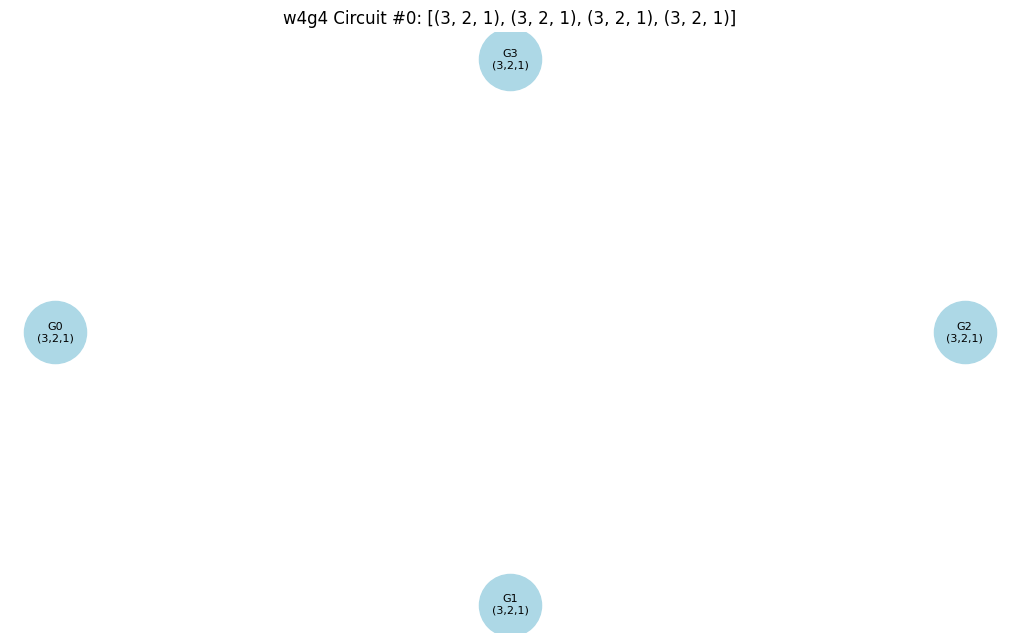

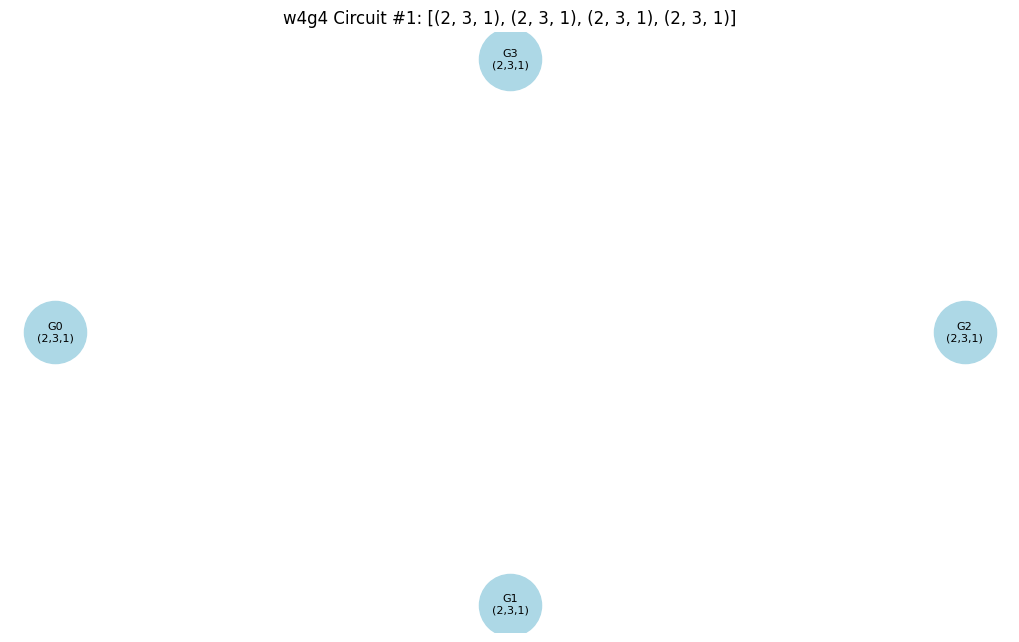

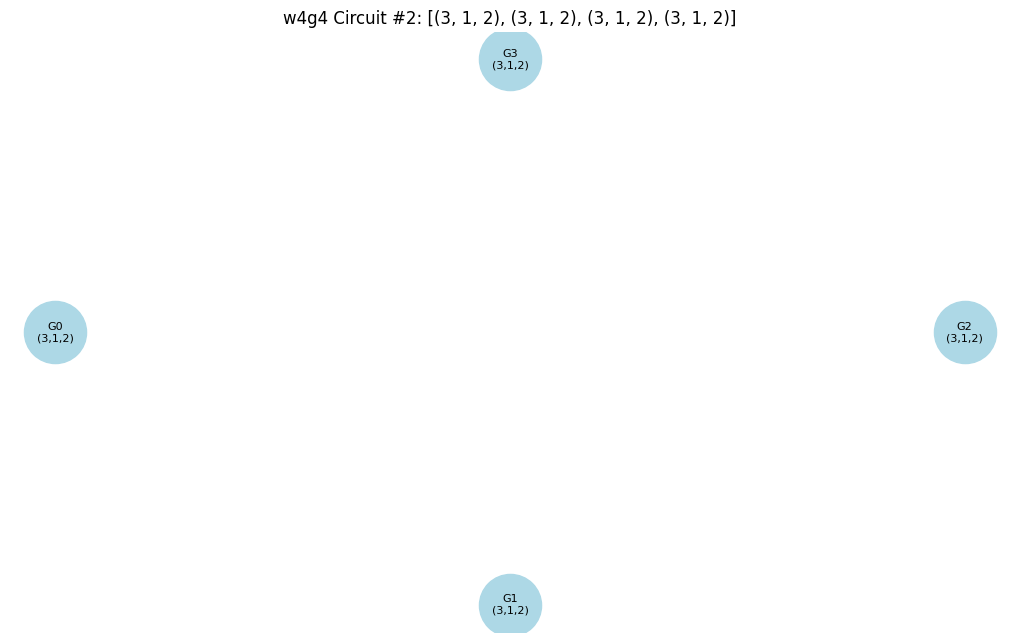

In [8]:
# Visualize a few sample circuits
for i in range(3):
    c = all_circuits['w4g4'][i]
    draw_eca57_skeleton(c, f'w4g4 Circuit #{i}: {c.to_tuple_list()}')

## 7. Find Irreducible Circuits

In [9]:
def is_reducible(circuit, smaller_identities):
    """Check if circuit contains any smaller identity as subcircuit."""
    for identity in smaller_identities:
        if circuit.contains(identity):
            return True
    return False

# Find irreducible w4g6 circuits (those not containing w4g4 or w4g2 subcircuits)
if 'w4g6' in all_circuits and 'w4g4' in all_circuits:
    smaller = all_circuits['w4g2'] + all_circuits['w4g4']
    
    irreducible = []
    reducible = []
    
    print(f'Checking {len(all_circuits["w4g6"])} w4g6 circuits...')
    for i, c in enumerate(all_circuits['w4g6']):
        if i % 500 == 0:
            print(f'  Checked {i}...')
        if is_reducible(c, smaller):
            reducible.append(c)
        else:
            irreducible.append(c)
    
    print(f'\n=== Irreducibility Analysis ===')
    print(f'w4g6 total: {len(all_circuits["w4g6"])}')
    print(f'Reducible: {len(reducible)}')
    print(f'Irreducible: {len(irreducible)}')
    print(f'Irreducible %: {100*len(irreducible)/len(all_circuits["w4g6"]):.1f}%')

Checking 103632 w4g6 circuits...
  Checked 0...
  Checked 500...
  Checked 1000...
  Checked 1500...
  Checked 2000...
  Checked 2500...
  Checked 3000...
  Checked 3500...
  Checked 4000...
  Checked 4500...
  Checked 5000...
  Checked 5500...
  Checked 6000...
  Checked 6500...
  Checked 7000...
  Checked 7500...
  Checked 8000...
  Checked 8500...
  Checked 9000...
  Checked 9500...
  Checked 10000...
  Checked 10500...
  Checked 11000...
  Checked 11500...
  Checked 12000...
  Checked 12500...
  Checked 13000...
  Checked 13500...
  Checked 14000...
  Checked 14500...
  Checked 15000...
  Checked 15500...
  Checked 16000...
  Checked 16500...
  Checked 17000...
  Checked 17500...
  Checked 18000...
  Checked 18500...
  Checked 19000...
  Checked 19500...
  Checked 20000...
  Checked 20500...
  Checked 21000...
  Checked 21500...
  Checked 22000...
  Checked 22500...
  Checked 23000...
  Checked 23500...
  Checked 24000...
  Checked 24500...
  Checked 25000...
  Checked 25500...
  C

## 8. Classify by Skeleton Structure

In [10]:
def skeleton_signature(circuit):
    """Create a signature for skeleton graph classification."""
    G = build_eca57_skeleton(circuit)
    edges = G.number_of_edges()
    in_deg = tuple(sorted(dict(G.in_degree()).values()))
    out_deg = tuple(sorted(dict(G.out_degree()).values()))
    return (edges, in_deg, out_deg)

# Classify w4g4 circuits by skeleton signature
signature_classes = defaultdict(list)
for c in all_circuits['w4g4']:
    sig = skeleton_signature(c)
    signature_classes[sig].append(c)

print(f'\n=== Skeleton Structure Classes (w4g4) ===')
print(f'Number of distinct signatures: {len(signature_classes)}')
print('\nTop 10 most common structures:')
for sig, circs in sorted(signature_classes.items(), key=lambda x: -len(x[1]))[:10]:
    edges, in_deg, out_deg = sig
    print(f'  edges={edges}, in_deg={in_deg}, out_deg={out_deg}: {len(circs)} circuits')


=== Skeleton Structure Classes (w4g4) ===
Number of distinct signatures: 4

Top 10 most common structures:
  edges=0, in_deg=(0, 0, 0, 0), out_deg=(0, 0, 0, 0): 624 circuits
  edges=2, in_deg=(0, 0, 1, 1), out_deg=(0, 0, 0, 2): 384 circuits
  edges=3, in_deg=(0, 1, 1, 1), out_deg=(0, 0, 1, 2): 192 circuits
  edges=1, in_deg=(0, 0, 0, 1), out_deg=(0, 0, 0, 1): 96 circuits


## 9. Gate Collision Analysis

In [11]:
def count_collisions(circuit):
    """Count number of gate collisions in circuit."""
    gates = circuit.gates()
    collisions = 0
    for i in range(len(gates) - 1):
        if gates[i].collides(gates[i+1]):
            collisions += 1
    return collisions

# Analyze collision patterns
for key in ['w4g4', 'w4g6']:
    if key not in all_circuits:
        continue
    collision_counts = [count_collisions(c) for c in all_circuits[key]]
    print(f'\n=== Collision Analysis: {key} ===')
    print(f'Mean collisions: {np.mean(collision_counts):.2f}')
    print(f'Min: {min(collision_counts)}, Max: {max(collision_counts)}')
    
    # Distribution
    counts = Counter(collision_counts)
    print('Distribution:')
    for c, n in sorted(counts.items()):
        print(f'  {c} collisions: {n} circuits ({100*n/len(collision_counts):.1f}%)')


=== Collision Analysis: w4g4 ===
Mean collisions: 0.89
Min: 0, Max: 2
Distribution:
  0 collisions: 528 circuits (40.7%)
  1 collisions: 384 circuits (29.6%)
  2 collisions: 384 circuits (29.6%)

=== Collision Analysis: w4g6 ===
Mean collisions: 1.72
Min: 0, Max: 5
Distribution:
  0 collisions: 17088 circuits (16.5%)
  1 collisions: 24144 circuits (23.3%)
  2 collisions: 40224 circuits (38.8%)
  3 collisions: 15744 circuits (15.2%)
  4 collisions: 6144 circuits (5.9%)
  5 collisions: 288 circuits (0.3%)


## 10. Hardness Metrics

In [12]:
def compute_hardness(circuit):
    """Compute hardness metrics for a circuit."""
    G = build_eca57_skeleton(circuit)
    gates = circuit.gates()
    
    # Various hardness metrics
    return {
        'gate_count': len(gates),
        'collisions': count_collisions(circuit),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'unique_targets': len(set(g.target for g in gates)),
        'max_chain': nx.dag_longest_path_length(G) if nx.is_directed_acyclic_graph(G) else -1
    }

# Find hardest circuits (most collisions + most edges)
key = 'w4g6' if 'w4g6' in all_circuits else 'w4g4'
hardness_scores = []
for c in all_circuits[key]:
    h = compute_hardness(c)
    score = h['collisions'] + h['edges']  # Simple combined score
    hardness_scores.append((score, h, c))

hardness_scores.sort(key=lambda x: -x[0])

print(f'\n=== Top 5 Hardest Circuits ({key}) ===')
for i, (score, h, c) in enumerate(hardness_scores[:5]):
    print(f'\n#{i+1}: Score={score}')
    print(f'  Circuit: {c.to_tuple_list()}')
    print(f'  Metrics: {h}')


=== Top 5 Hardest Circuits (w4g6) ===

#1: Score=13
  Circuit: [(3, 2, 0), (2, 0, 3), (0, 2, 3), (0, 2, 3), (2, 0, 3), (3, 2, 0)]
  Metrics: {'gate_count': 6, 'collisions': 4, 'edges': 9, 'density': 0.3, 'unique_targets': 3, 'max_chain': 4}

#2: Score=13
  Circuit: [(2, 3, 0), (3, 0, 2), (0, 3, 2), (0, 3, 2), (3, 0, 2), (2, 3, 0)]
  Metrics: {'gate_count': 6, 'collisions': 4, 'edges': 9, 'density': 0.3, 'unique_targets': 3, 'max_chain': 4}

#3: Score=13
  Circuit: [(3, 1, 0), (1, 0, 3), (0, 1, 3), (0, 1, 3), (1, 0, 3), (3, 1, 0)]
  Metrics: {'gate_count': 6, 'collisions': 4, 'edges': 9, 'density': 0.3, 'unique_targets': 3, 'max_chain': 4}

#4: Score=13
  Circuit: [(1, 3, 0), (3, 0, 1), (0, 3, 1), (0, 3, 1), (3, 0, 1), (1, 3, 0)]
  Metrics: {'gate_count': 6, 'collisions': 4, 'edges': 9, 'density': 0.3, 'unique_targets': 3, 'max_chain': 4}

#5: Score=13
  Circuit: [(2, 1, 0), (1, 0, 2), (0, 1, 2), (0, 1, 2), (1, 0, 2), (2, 1, 0)]
  Metrics: {'gate_count': 6, 'collisions': 4, 'edges': 9,

## 11. Save Analysis Results

In [13]:
# Save irreducible circuits if found
if 'irreducible' in dir() and len(irreducible) > 0:
    irreducible_data = {
        'width': 4,
        'gate_count': 6,
        'circuits': [c.to_tuple_list() for c in irreducible]
    }
    
    out_path = '/Users/egementunca/research-group/sat_revsynth/data/eca57_irreducible_w4g6.pickle'
    with open(out_path, 'wb') as f:
        pickle.dump(irreducible_data, f)
    print(f'Saved {len(irreducible)} irreducible circuits to {out_path}')
else:
    print('No irreducible circuits to save (run cell 7 first)')

Saved 6816 irreducible circuits to /Users/egementunca/research-group/sat_revsynth/data/eca57_irreducible_w4g6.pickle
